In [1]:
import bioframe
import pandas as pd
import requests
import numpy as np
import bbi
import matplotlib.pyplot as plt
import matplotlib.colors as colors

sdir = '/scratch/pokorny/Elphege_2017/'

# Mapping RefSeq transcripts to RNA_seq results to assign TSS

- First, importing and cleaning RefSeq to get only transcripts 
- Then, using bioframe and pandas functions to assign only one TSS to each row in RNA-seq results

In [2]:
#Download Supplementary Table3 RNA-seq FPKM values, Related to figure 6 
RNA_seq_FPKM = pd.read_excel('/scratch/pokorny/Elphege_2017/sup_data/NIHMS873912-supplement-10.xlsx', skiprows=6, usecols="A:G, O:Q")

RNA_seq_FPKM = RNA_seq_FPKM.rename(columns={'untreated': 'CTCF-AID_untreated', '1day': 'CTCF-AID_1day', '2days': 'CTCF-AID_2days', '4days': 'CTCF-AID_4days',
                                '2days_washoff_2days' : 'CTCF-AID_washoff', 'untreated.1' : 'WT_untreated', '2days.3' : 'WT_2days', '4days.3' : 'WT_4days'})

print(RNA_seq_FPKM.shape)

(24315, 10)


In [3]:
RNA_seq_FPKM[0:5]

,tracking_id,locus,CTCF-AID_untreated,CTCF-AID_1day,CTCF-AID_2days,CTCF-AID_4days,CTCF-AID_washoff,WT_untreated,WT_2days,WT_4days
0,0610005C13Rik,chr7:52823164-52845080,0.784511,0.804255,1.040841,2.176798,1.209881,0.531110,0.539697,0.414068
1,0610007P14Rik,chr12:87156404-87165495,71.716133,74.856200,63.412767,59.250033,67.995733,57.020867,49.716167,57.023633
2,0610009B22Rik,chr11:51498886-51502136,69.529333,76.436433,61.336067,38.937500,58.353700,58.497000,46.990267,58.072767
3,0610009L18Rik,chr11:120209991-120212504,0.944842,1.154941,0.905838,1.097459,0.889548,1.180704,1.977405,0.825640
4,0610009O20Rik,chr18:38398058-38422283,17.565900,20.652933,20.476800,20.633733,18.857300,18.864133,18.413433,18.779333


In [4]:
# Parsing UCSC region into bioframe triple
RNA_seq_FPKM[['chrom', 'start', 'end']] = RNA_seq_FPKM.apply(lambda row: bioframe.parse_region_string(row['locus']), axis=1, result_type='expand')

In [5]:
# Import RefSeq transcript annotations and find closest with bioframe

# Adding header from GTF filetype description: https://genome.ucsc.edu/FAQ/FAQformat.html#format4 
refGenes = pd.read_table('/scratch/pokorny/genomic_annotations/mm9.refGene.gtf', header=None, 
                         names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame',
                                'attributes'])

# Get transcripts only
refTranscripts = refGenes.loc[refGenes['feature'] == 'transcript'].copy()
refTranscripts = refTranscripts.rename(columns={'seqname' : 'chrom'})

# Create a column of the TSS start site (might be unnecessary, but we'll keep it here for reference later)
refTranscripts['TSS_loc'] = np.where((refTranscripts['strand'] == '+'), refTranscripts['start'], refTranscripts['end'])


In [6]:
# Cleaning out the randos
refTranscripts = refTranscripts.loc[False==( refTranscripts['chrom'].str.contains('_random'))]

In [7]:
np.unique(refTranscripts['chrom'])

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr3', 'chr4', 'chr5',
       'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY'], dtype=object)

In [8]:
# Mapping transcript intervals to RNA_seq intervals
df_RNA_seq_FPKM_refTSS = bioframe.overlap(RNA_seq_FPKM, refTranscripts, suffixes=('','_ref'))

# Getting overlap to first, choose whichever has largest overlap
df_RNA_seq_FPKM_refTSS['overlap_len'] = df_RNA_seq_FPKM_refTSS.apply(lambda row: 
                                                                     np.abs(np.minimum(row['start'] , row['start_ref']) - np.maximum(row['end'], row['end_ref'])),
                                                                     axis=1)

# Get whoever has closest overlap (where distance is defined by squared distance between starts and ends)
df_RNA_seq_FPKM_refTSS['overlap_sq_dist'] = df_RNA_seq_FPKM_refTSS.apply(lambda row: 
                                                                     np.sqrt(np.abs(np.square(row['start'] - row['start_ref']) - np.square(row['end'] - row['end_ref']))),
                                                                     axis=1)

In [9]:
# Getting rid of the RNAseq rows that did not have an overlap with the RefSeq genes
print('Number of rows deleted: ')
print(df_RNA_seq_FPKM_refTSS['overlap_sq_dist'].isna().sum())
df_RNA_seq_FPKM_refTSS = df_RNA_seq_FPKM_refTSS.loc[False==df_RNA_seq_FPKM_refTSS['overlap_sq_dist'].isna()]


Number of rows deleted: 
75


In [10]:
df_RNA_seq_FPKM_refTSS['overlap_sq_dist'] = pd.to_numeric( df_RNA_seq_FPKM_refTSS['overlap_sq_dist'])
df_RNA_seq_FPKM_refTSS['TSS_loc_ref'] = pd.to_numeric( df_RNA_seq_FPKM_refTSS['TSS_loc_ref'])

In [11]:
# Assign the transcript with the greatest amount of overlap to the RNAseq read (smallest squared overlap distance)
mindist_idx = df_RNA_seq_FPKM_refTSS.groupby(["chrom", "start","end"])['overlap_sq_dist'].idxmin()
df_RNA_seq_FPKM_refTSS = df_RNA_seq_FPKM_refTSS.loc[mindist_idx]

In [12]:
# What is the final dataset like? 
print("Size of original RNA_seq dataset: " + str(len(RNA_seq_FPKM)))
print("Size of RNA_seq dataset after mapping closest transcript, removing any that had no match: " + str(len(df_RNA_seq_FPKM_refTSS)))
print(df_RNA_seq_FPKM_refTSS.columns)
df_RNA_seq_FPKM_refTSS[0:5]

Size of original RNA_seq dataset: 24315
Size of RNA_seq dataset after mapping closest transcript, removing any that had no match: 21114
Index(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_1day',
       'CTCF-AID_2days', 'CTCF-AID_4days', 'CTCF-AID_washoff', 'WT_untreated',
       'WT_2days', 'WT_4days', 'chrom', 'start', 'end', 'chrom_ref',
       'source_ref', 'feature_ref', 'start_ref', 'end_ref', 'score_ref',
       'strand_ref', 'frame_ref', 'attributes_ref', 'TSS_loc_ref',
       'overlap_len', 'overlap_sq_dist'],
      dtype='object')


,tracking_id,locus,CTCF-AID_untreated,CTCF-AID_1day,CTCF-AID_2days,CTCF-AID_4days,CTCF-AID_washoff,WT_untreated,WT_2days,WT_4days,...,feature_ref,start_ref,end_ref,score_ref,strand_ref,frame_ref,attributes_ref,TSS_loc_ref,overlap_len,overlap_sq_dist
75507,Xkr4,chr1:3204562-3661579,0.079429,0.080038,0.160025,0.183129,0.082974,0.100821,0.048817,0.048705,...,transcript,3204563,3661579,.,-,.,"gene_id ""Xkr4""; transcript_id ""NM_001011874""; ...",3661579.0,457017,1.0
63963,Rp1,chr1:4280926-4399322,0.010000,0.010000,0.012304,0.018491,0.010000,0.010000,0.015472,0.014212,...,transcript,4280927,4399322,.,-,.,"gene_id ""Rp1""; transcript_id ""NM_001195662""; ...",4399322.0,118396,1.0
68364,Sox17,chr1:4481008-4487435,2.822350,3.394300,4.101817,9.904437,4.904270,2.788743,1.955637,3.296768,...,transcript,4481009,4487435,.,-,.,"gene_id ""Sox17""; transcript_id ""NM_001289465"";...",4487435.0,6427,1.0
49874,Mrpl15,chr1:4763278-4775807,110.529800,114.840767,82.174500,63.618100,88.150000,81.863667,72.279867,77.639300,...,transcript,4763279,4775807,.,-,.,"gene_id ""Mrpl15""; transcript_id ""NM_025300""; ...",4775807.0,12529,1.0
29935,Lypla1,chr1:4797973-4836816,63.505700,68.842267,67.116867,69.617000,70.611100,54.741200,40.829400,54.832533,...,transcript,4797904,4836816,.,+,.,"gene_id ""Lypla1""; transcript_id ""NM_008866""; ...",4797904.0,38912,69.0


# Generating Fig. 6 a,b using multiple datasets

1. Using Supplementary excel file NIHMS873912-supplement-10.xlsx for RNA-seq differential expression, using mm9 RefSeq transcripts

2. Using Supplementary excel file NIHMS873912-supplement-10.xlsx for RNA-seq differential expression, using Elphege's gene list with one TSS

3. With sleuth RNA-seq differential analysis dataset, 
   1. Note: do not have raw RNA_seq fastq files for this, so will have to try sleuth differential analysis another way

## Generating delta FPKM dataframes for each time interval, examine CTCF binding

Getting change in expression from untreated to 1 days of auxin treatment, 2 days of auxin treatment, 4 days of auxin treatment, then after the wash. 

In [13]:
## Generates a new column that has the delta fpkm between two columns for one row (or one gene) and 
# sorts the input dateframe by that column. 
# Adds the new column to input df. fpkm_0 is the name of the column in the initial state, fpkm_x is 
# the name of the column in the changed state.
def generate_log10_deltaFPKM(df, fpkm_0, fpkm_x):
    df['log10FoldChange'] = df.apply(lambda row: np.log10(row[fpkm_x] / row[fpkm_0]), axis=1)
    #df['log10_delta'] = np.log10(df['delta']).copy()
    df = df.sort_values(by='log10FoldChange', ascending=False)
    
    return df

### After 1 day of auxin treatment compare differential expression and CTCF binding at TSS

In [23]:
# Group FPKM data according to change in expression from untreated to 1 of auxin treatment
oneDay_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_1day', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
oneDay_RNAseq_change = generate_log10_deltaFPKM(oneDay_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_1day')
oneDay_RNAseq_change = oneDay_RNAseq_change.reset_index()

oneDay_RNAseq_change[-5:]

,index,tracking_id,locus,CTCF-AID_untreated,CTCF-AID_1day,chrom,start,end,TSS_loc_ref,log10FoldChange
21109,47960,Mir684-2,chr4:11061243-11061329,374.042333,0.01,chr4,11061243,11061329,11061244.0,-4.572921
21110,31965,Mir1982,chr10:80289400-80292035,670.731667,0.01,chr10,80289400,80292035,80289401.0,-4.826549
21111,48086,Mir6926,chr11:74662765-74710582,725.160000,0.01,chr11,74662765,74710582,74710582.0,-4.860434
21112,67868,Snord104,chr11:106362304-106362377,862.090000,0.01,chr11,106362304,106362377,106362305.0,-4.935553
21113,48598,Mir7049,chr7:29343837-29383203,1530.793333,0.01,chr7,29343837,29383203,29383203.0,-5.184917


Are any of these deltas negative? should have both increased and decreased expression

caught an error in my dFPKM formular from before. Changed to: (FPKM_treated - FPKM_untreated) / FPKM_untreated

In [24]:
oneDay_RNAseq_change[oneDay_RNAseq_change['log10FoldChange'] < 0]

,index,tracking_id,locus,CTCF-AID_untreated,CTCF-AID_1day,chrom,start,end,TSS_loc_ref,log10FoldChange
12269,69536,Sult1b1,chr5:87942363-87967220,0.013365,0.013364,chr5,87942363,87967220,87967220.0,-0.000032
12270,8025,Bcl9,chr3:97007584-97031287,4.296067,4.295703,chr3,97007584,97031287,97031287.0,-0.000037
12271,52446,Nup107,chr10:117187698-117229761,70.910100,70.903267,chr10,117187698,117229761,117229761.0,-0.000042
12272,65321,Sepn1,chr4:134093806-134108081,1.412840,1.412664,chr4,134093806,134108081,134108081.0,-0.000054
12273,73324,Ttc30a2,chr2:75814228-75816236,0.392804,0.392747,chr2,75814228,75816236,75816236.0,-0.000063
...,...,...,...,...,...,...,...,...,...,...
21109,47960,Mir684-2,chr4:11061243-11061329,374.042333,0.010000,chr4,11061243,11061329,11061244.0,-4.572921
21110,31965,Mir1982,chr10:80289400-80292035,670.731667,0.010000,chr10,80289400,80292035,80289401.0,-4.826549
21111,48086,Mir6926,chr11:74662765-74710582,725.160000,0.010000,chr11,74662765,74710582,74710582.0,-4.860434
21112,67868,Snord104,chr11:106362304-106362377,862.090000,0.010000,chr11,106362304,106362377,106362305.0,-4.935553


## Figure 6(a)

RNA-seq. fold change compared to untreated cells for genes differentially expressed at one or more time points. Wash denotes 2-day washoff after a 2-day treatment

In [25]:
oneDay_RNAseq_change.dtypes

index                   int64
tracking_id            object
locus                  object
CTCF-AID_untreated    float64
CTCF-AID_1day         float64
chrom                  object
start                   Int64
end                     Int64
TSS_loc_ref           float64
log10FoldChange       float64
dtype: object

## Figure 6(b)

In [26]:

with bbi.open(sdir + "GSM2609195_CTCF_ChIP-exo_WT-untagged_untreated_rep1_ENC1_tagDensity.bw") as f:
    
    matrix = f.stackup(oneDay_RNAseq_change['chrom'], oneDay_RNAseq_change['TSS_loc_ref'] - 1000, oneDay_RNAseq_change['TSS_loc_ref'] + 1000, bins=20)

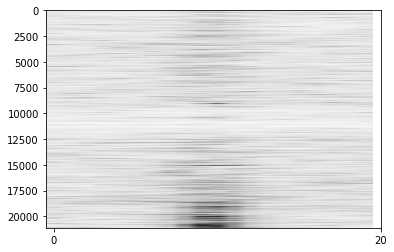

In [112]:
fig, ax = plt.subplots(1,1)

fig = plt.imshow(matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
ax.set_xticks([0, 20])

# todo: set axis labels according to bp from TSS, instead of buckets, without changing scale
plt.show()

This is more consistent with the figure produced by Elphege et. al. yay! Going to filter to extract only the differentially expressed genes as well, for a closer look.
Noticed that in Elphege's Fig. 6(b), they have n=370 for day 1 treatment, n=1300 for day 2, etc. Looks like they were filtering for only the differentially expressed genes as well (should have noticed)

Tried cutoffs: 0.01, 0.1, 1.0, 2.0, 5.0 

In [17]:
cutoffs = [0.0, 0.01, 0.1, 1.0, 2.0, 5.0]

def checkCutoff(cutoffs, RNAseq_change_df):
    for cutoff in cutoffs:
        print()
        print("Setting cutoff to: " + str(cutoff))
        DEs = RNAseq_change_df.loc[(RNAseq_change_df['log10FoldChange'].abs()) > cutoff]
        n = len(DEs)
        n_up = len(DEs[DEs['log10FoldChange'] > 0])
        n_down = len(DEs[DEs['log10FoldChange'] < 0])
        print("Number of differentially expressed genes with this cutoff: " + str(n))
        print("Number of up-regulated genes: " + str(n_up))
        print("Number of down-regulated genes: " + str(n_down))
        
checkCutoff(cutoffs, oneDay_RNAseq_change)


Setting cutoff to: 0.0
Number of differentially expressed genes with this cutoff: 18302
Number of up-regulated genes: 9457
Number of down-regulated genes: 8845

Setting cutoff to: 0.01
Number of differentially expressed genes with this cutoff: 16639
Number of up-regulated genes: 8639
Number of down-regulated genes: 8000

Setting cutoff to: 0.1
Number of differentially expressed genes with this cutoff: 7468
Number of up-regulated genes: 4226
Number of down-regulated genes: 3242

Setting cutoff to: 1.0
Number of differentially expressed genes with this cutoff: 136
Number of up-regulated genes: 61
Number of down-regulated genes: 75

Setting cutoff to: 2.0
Number of differentially expressed genes with this cutoff: 44
Number of up-regulated genes: 20
Number of down-regulated genes: 24

Setting cutoff to: 5.0
Number of differentially expressed genes with this cutoff: 2
Number of up-regulated genes: 1
Number of down-regulated genes: 1


Choosing cutoff of 1.0 so that log actually makes sense :-), but doesn't capture the under-expressed genes. Also producing a map that does not take log-val of delta FPKM so we can see some of the under-expressed genes. I'll check on the delta cutoffs for the other time-frames too to compare, we might be able to keep the cutoff > 1.0 for them.

In [27]:

## For plotting the log change in FPKM, as a measure of differential expression, alongside the binding of 
## that transcript at it's TSS.
# 
# cutoff: the deltaFPKM to take
# DE_df: must have the columns 'delta' for the FPKM, must be in sorted order by delta
# CTCF ChIP-exo filepath
def plot_logFPKM_CTCF_binding(cutoff, DE_df, chip_seq_file, plot_title):

    # Extracting only rows that are above the cutoff
    window_df = DE_df.loc[(DE_df['log10FoldChange'].abs()) > cutoff]
    
    
    # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
    with bbi.open(chip_seq_file) as f:
        DE_matrix = f.stackup(window_df['chrom'], window_df['TSS_loc_ref'] - 1000, window_df['TSS_loc_ref'] + 1000, bins=20)
        

    # Getting plots ready
    fig, ax = plt.subplots(1,2)
    
    # split by positive and negative values for plotting
    DE_up = window_df[window_df['log10FoldChange'] > 0]
    DE_down = window_df[window_df['log10FoldChange'] < 0]
    
    n = len(window_df)
    n_up = len(DE_up)
    n_down = len(DE_down)
    
    print("Setting cutoff to: " + str(cutoff))
    print("Number of differentially expressed genes with this cutoff: " + str(n))
    print("Number of up-regulated genes: " + str(n_up))
    print("Number of down-regulated genes: " + str(n_down))
    

    # extracting the log10fold change vector
    logFPKM = window_df['log10FoldChange']
    logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
    minval=np.min(logFPKM)
    maxval=np.max(logFPKM)
    # if diverging, color negative values blue
    if (minval < 0):
        divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
        occ = ax[0].imshow(logFPKM, cmap='RdBu', norm=divnorm, aspect='auto')
    # pcolormesh(your_data, cmap="coolwarm", norm=divnorm)
    else:
        minval= 0
        occ = ax[0].imshow(logFPKM, cmap='Reds', norm=colors.Normalize(vmin=0, vmax=1), aspect='auto')
        

    fig.colorbar(occ, ax=ax[0], extend='max')
    fig.suptitle(plot_title)
    # Plotting ctcf binding
    fig = ax[1].imshow(DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
    ax[1].set_xticks([0, 20])
    

    plt.show()

Setting cutoff to: 1.0
Number of differentially expressed genes with this cutoff: 136
Number of up-regulated genes: 61
Number of down-regulated genes: 75


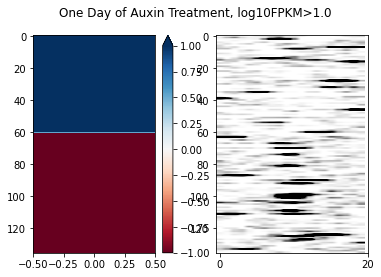

In [28]:
cutoff = 1.0

#oneDay_RNAseq_change_DEs = oneDay_RNAseq_change.loc[(oneDay_RNAseq_change['delta'].abs()) > cutoff]
#window_df = oneDay_RNAseq_change_DEs
ctcf_binding_file = sdir + "GSM2609195_CTCF_ChIP-exo_WT-untagged_untreated_rep1_ENC1_tagDensity.bw"

plot_logFPKM_CTCF_binding(cutoff, oneDay_RNAseq_change, ctcf_binding_file, 'One Day of Auxin Treatment, log10FPKM>1.0')

Trying with all the data points, cutoff=0

Setting cutoff to: 0.0
Number of differentially expressed genes with this cutoff: 18302
Number of up-regulated genes: 9457
Number of down-regulated genes: 8845


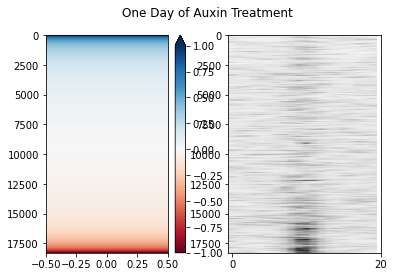

In [20]:
# Trying with all of the data-points
oneDay_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_1day', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
oneDay_RNAseq_change = generate_log10_deltaFPKM(oneDay_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_1day')

plot_logFPKM_CTCF_binding(0.0, oneDay_RNAseq_change, ctcf_binding_file, 'One Day of Auxin Treatment')

Try same thing, but without taking log of delta FPKM so that we don't lose the negative values / ones too close to the cutoff

### Do the same for the rest of the time intervals

Gathering the needed data into one aggregate form, to pass into function. This is probably most analogous to a useful function when dealing with less-structured/raw data (vs downloading from excel files) 

In [29]:
# Trying with all of the data-points
oneDay_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_1day', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
oneDay_RNAseq_change = generate_log10_deltaFPKM(oneDay_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_1day')

# Group FPKM data according to change in expression from untreated to 2days of auxin treatment
twoDay_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_2days', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
twoDay_RNAseq_change = generate_log10_deltaFPKM(twoDay_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_2days')

# Group FPKM data according to change in expression from untreated to 4days of auxin treatment
fourDay_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_4days', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
fourDay_RNAseq_change = generate_log10_deltaFPKM(fourDay_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_4days')

# Group FPKM data according to change in expression following wash-off of auxin treatment
washOff_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_washoff', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
washOff_RNAseq_change = generate_log10_deltaFPKM(washOff_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_washoff')

RNAseq_changes = {"One Day of Auxin Treatment" :  oneDay_RNAseq_change,
                  "Two Days of Auxin Treatment" : twoDay_RNAseq_change,
                 "Four Days of Auxin Treatment" : fourDay_RNAseq_change,
                 "Washoff Auxin" : washOff_RNAseq_change}

Setting cutoff to: 0.1 for set One Day of Auxin Treatment
Number of differentially expressed genes with this cutoff: 7468
Number of up-regulated genes: 4226
Number of down-regulated genes: 3242

Setting cutoff to: 0.1 for set Two Days of Auxin Treatment
Number of differentially expressed genes with this cutoff: 9824
Number of up-regulated genes: 5948
Number of down-regulated genes: 3876

Setting cutoff to: 0.1 for set Four Days of Auxin Treatment
Number of differentially expressed genes with this cutoff: 12613
Number of up-regulated genes: 7120
Number of down-regulated genes: 5493

Setting cutoff to: 0.1 for set Washoff Auxin
Number of differentially expressed genes with this cutoff: 7907
Number of up-regulated genes: 5039
Number of down-regulated genes: 2868



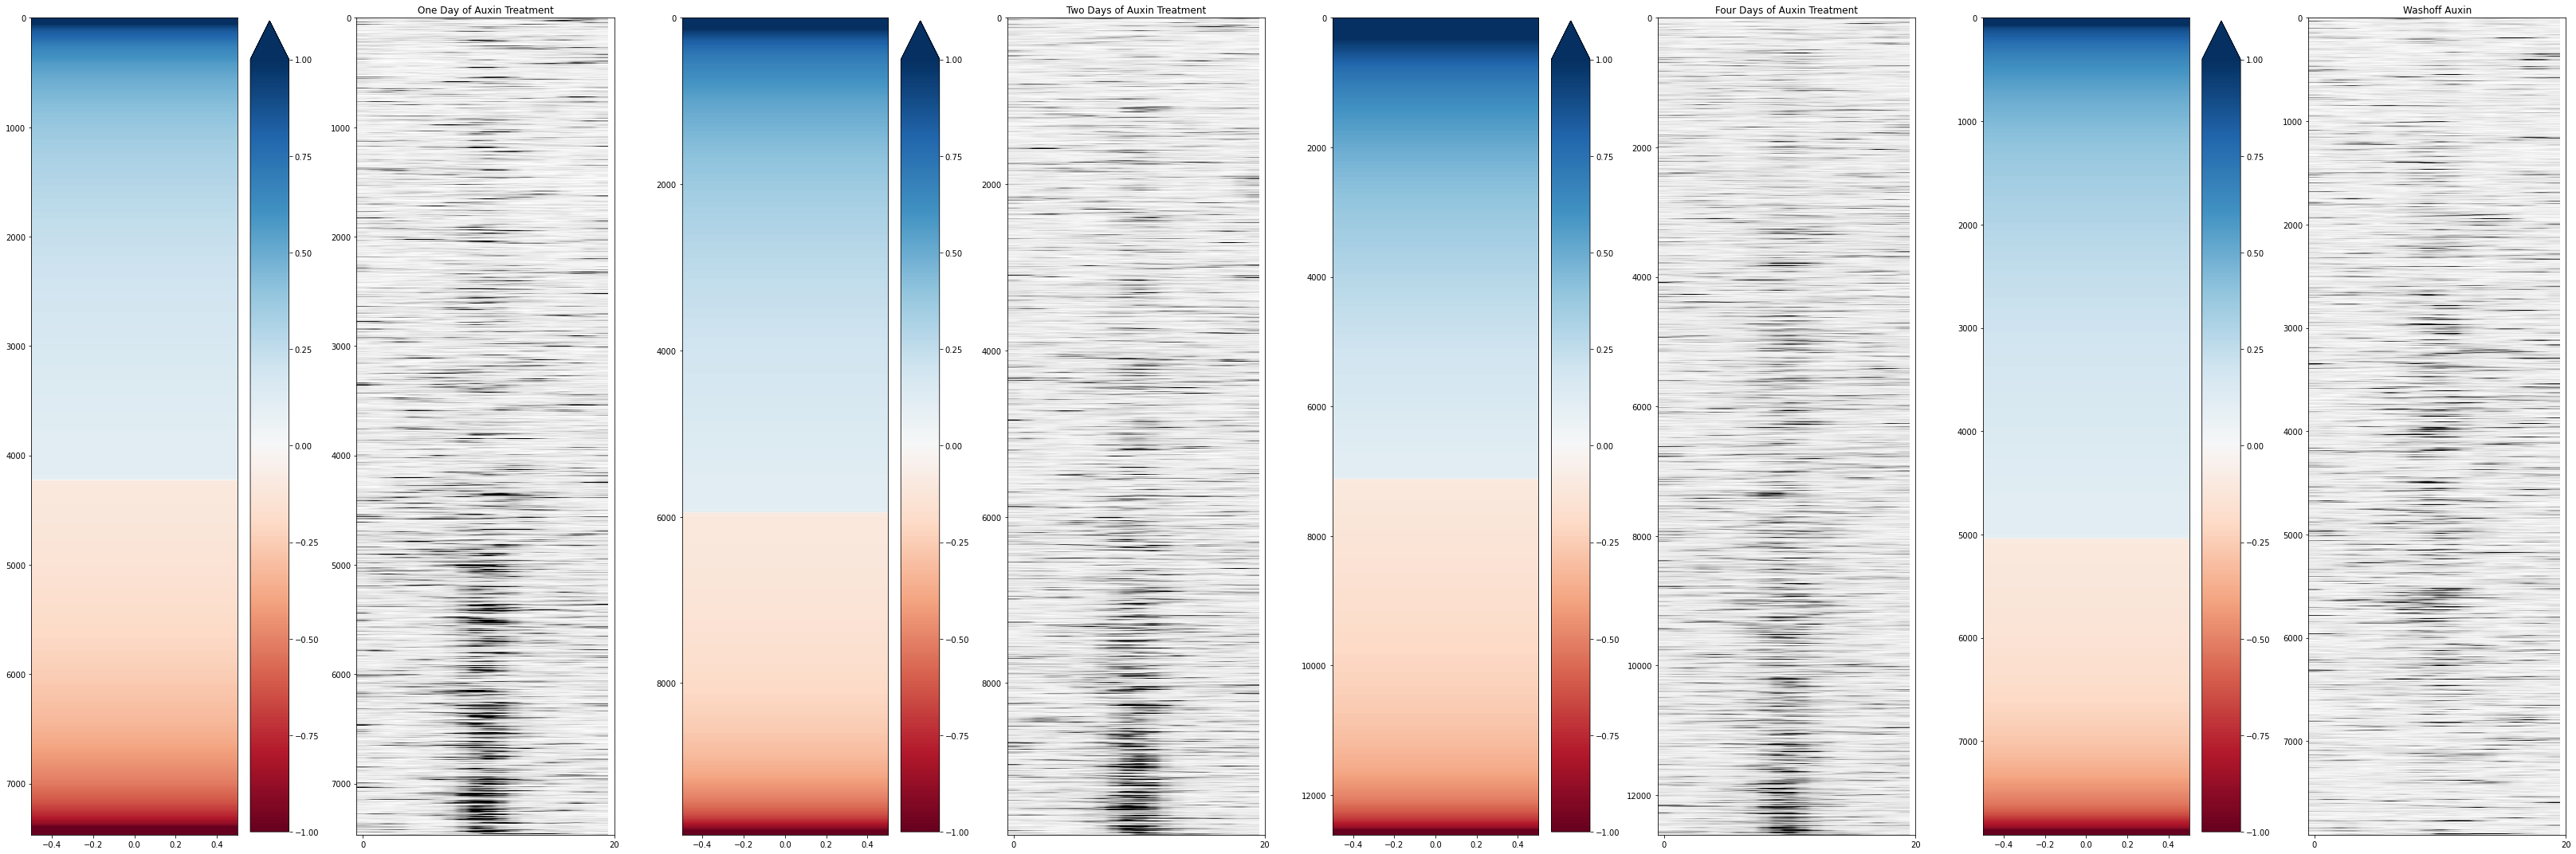

In [41]:
plot_logFPKM_CTCF_binding_together(0.1, RNAseq_changes, ctcf_binding_file)

Setting cutoff to: 0.0 for set One Day of Auxin Treatment
Number of differentially expressed genes with this cutoff: 18302
Number of up-regulated genes: 9457
Number of down-regulated genes: 8845

Setting cutoff to: 0.0 for set Two Days of Auxin Treatment
Number of differentially expressed genes with this cutoff: 18444
Number of up-regulated genes: 9498
Number of down-regulated genes: 8946

Setting cutoff to: 0.0 for set Four Days of Auxin Treatment
Number of differentially expressed genes with this cutoff: 18554
Number of up-regulated genes: 9779
Number of down-regulated genes: 8775

Setting cutoff to: 0.0 for set Washoff Auxin
Number of differentially expressed genes with this cutoff: 18383
Number of up-regulated genes: 9356
Number of down-regulated genes: 9027



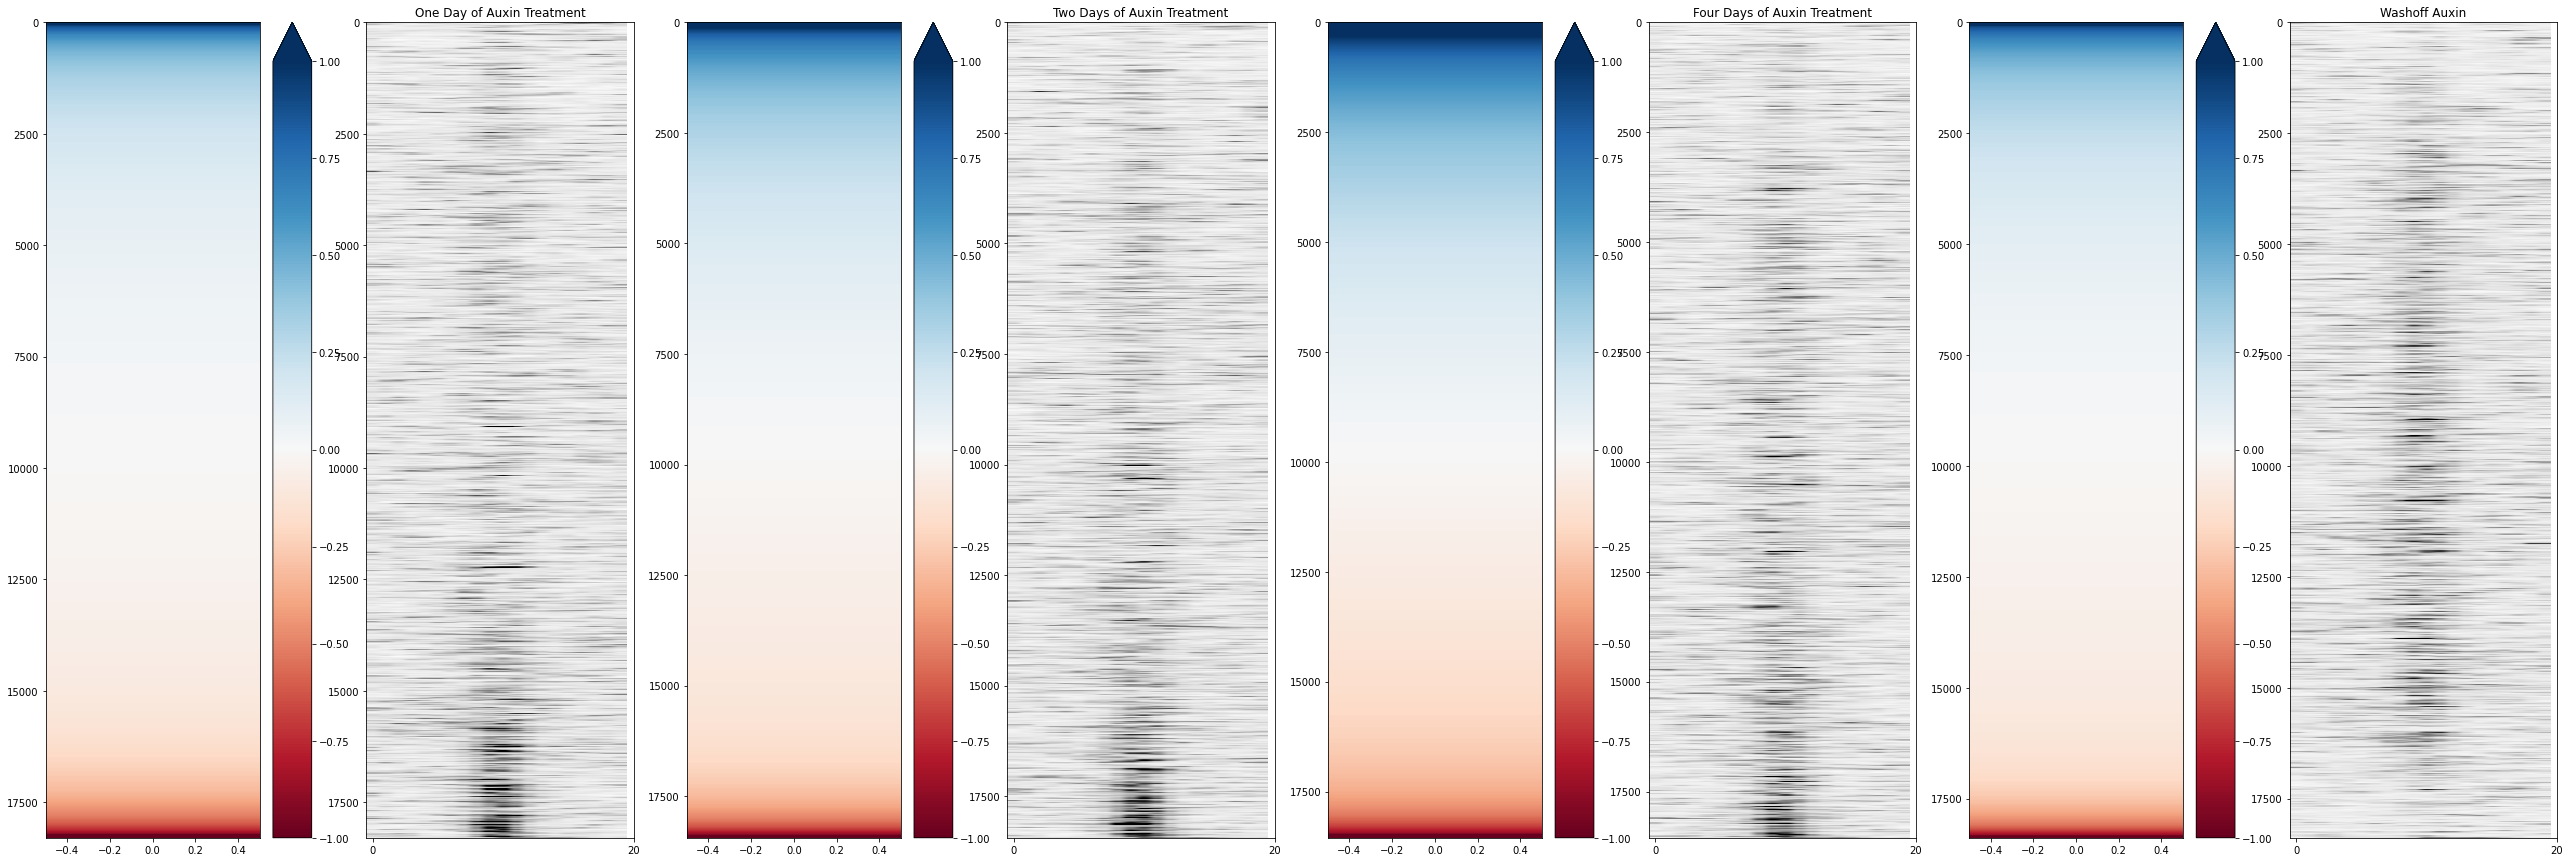

In [43]:
plot_logFPKM_CTCF_binding_together(0.0, RNAseq_changes, ctcf_binding_file)

In [42]:
## For plotting the log change in FPKM, as a measure of differential expression, alongside the binding of 
## that transcript at it's TSS.
# 
# cutoff: the deltaFPKM to take
# DE_df: must have the columns 'delta' for the FPKM, must be in sorted order by delta
# CTCF ChIP-exo filepath
def plot_logFPKM_CTCF_binding_together(cutoff, DE_df_dict, chip_seq_file):
    
    
    
    # Getting plots ready
    fig, ax = plt.subplots(1,2*len(DE_df_dict), figsize=(45, 15))
    i = 0
    
    for name, DE_df in DE_df_dict.items():

        # Extracting only rows that are above the cutoff
        window_df = DE_df.loc[(DE_df['log10FoldChange'].abs()) > cutoff]


        # Generating summary of chip seq signal within the bins -1000 and +1000 from the TSS loc
        with bbi.open(chip_seq_file) as f:
            DE_matrix = f.stackup(window_df['chrom'], window_df['TSS_loc_ref'] - 1000, window_df['TSS_loc_ref'] + 1000, bins=20)


        # split by positive and negative values for plotting
        DE_up = window_df[window_df['log10FoldChange'] > 0]
        DE_down = window_df[window_df['log10FoldChange'] < 0]

        n = len(window_df)
        n_up = len(DE_up)
        n_down = len(DE_down)

        print("Setting cutoff to: " + str(cutoff) + " for set " + name)
        print("Number of differentially expressed genes with this cutoff: " + str(n))
        print("Number of up-regulated genes: " + str(n_up))
        print("Number of down-regulated genes: " + str(n_down))
        print()


        # extracting the log10fold change vector
        logFPKM = window_df['log10FoldChange']
        logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
        minval=np.min(logFPKM)
        maxval=np.max(logFPKM)
        # if diverging, color negative values blue
        if (minval < 0):
            divnorm=colors.TwoSlopeNorm(vmin=-1, vcenter=0., vmax=1)
            occ = ax[i].imshow(logFPKM, cmap='RdBu', norm=divnorm, aspect='auto')
        # pcolormesh(your_data, cmap="coolwarm", norm=divnorm)
        else:
            minval= 0
            occ = ax[i].imshow(logFPKM, cmap='Reds', norm=colors.Normalize(vmin=0, vmax=1), aspect='auto')


        cbar = ax[i].figure.colorbar(occ, ax=ax[i], extend='max')
        i+=1
        
        ax[i].title.set_text(name)
        # Plotting ctcf binding
        fig = ax[i].imshow(DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
        ax[i].set_xticks([0, 20])
        i+=1

    plt.show()

# Playground / Scratch work for building the above functions or to save things that I tried and failed

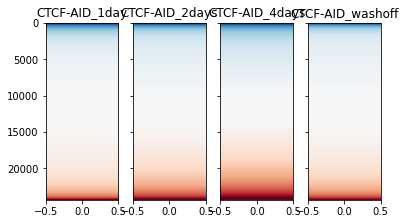

In [9]:
import matplotlib.colors as colors


# log FPMK values
def plotLogFPKM(dfList):
    
    fix, axis = plt.subplots(1, len(dfList), sharey=True)
    for fpkmDF,ax in zip(dfList, axis.flatten()):
        logFPKM = np.log10(fpkmDF['delta'])
        logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
        im = ax.imshow(logFPKM, cmap='RdBu', norm=colors.Normalize(vmin=-1, vmax=1), aspect=0.0001)
        ax.title.set_text(fpkmDF.columns.values[3])
        
        
    plt.show()
    

plotLogFPKM([oneDay_RNAseq_change, twoDay_RNAseq_change, fourDay_RNAseq_change, washOff_RNAseq_change])

Note: It looks like they sorted all the sets by one of dFPKM values, so that they could visualize changes to those particular sets/clusters as time went one (e.g. after washoff some clusters returned and others did not). Here, I did it differently because I sorted each set by the dFPKM.

Todo: re-generate clustered dataset (second part of Fig. 6a, assign clusters and maintain one indexed order)

In [10]:
# Assign TSS using bioframe only 


In [127]:
# Group FPKM data according to change in expression from untreated to 2days of auxin treatment
twoDay_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_2days', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
twoDay_RNAseq_change = generate_log10_deltaFPKM(twoDay_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_2days')

twoDay_RNAseq_change[0:5]

,tracking_id,locus,CTCF-AID_untreated,CTCF-AID_2days,chrom,start,end,TSS_loc_ref,log10FoldChange
47986,Mir6900,chr1:94336295-94370335,0.01,1716.360000,chr1,94336295,94370335,94370335.0,5.234608
48663,Mir7067,chr8:73418620-73421342,0.01,904.956667,chr8,73418620,73421342,73421342.0,4.956628
48109,Mir6930,chr11:102264294-102268831,0.01,396.323333,chr11,102264294,102268831,102268831.0,4.598050
40907,Mir497,chr11:70048193-70048318,0.01,274.111000,chr11,70048193,70048318,70048318.0,4.437926
48248,Mir697,chr4:124392104-124409666,0.01,248.792000,chr4,124392104,124409666,124392105.0,4.395836


Setting cutoff to: 0.1
Number of differentially expressed genes with this cutoff: 9824
Number of up-regulated genes: 5948
Number of down-regulated genes: 3876


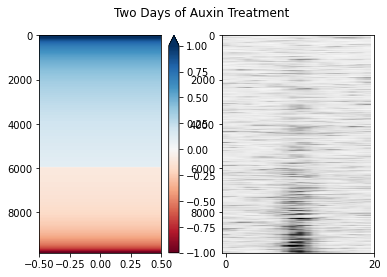

In [143]:
twoDay_dict = { "Two Days of Auxin Treatment" : twoDay_RNAseq_change}

plot_logFPKM_CTCF_binding_together(0.1, twoDay_dict, ctcf_binding_file)

Setting cutoff to: 0.0
Number of differentially expressed genes with this cutoff: 18444
Number of up-regulated genes: 9498
Number of down-regulated genes: 8946


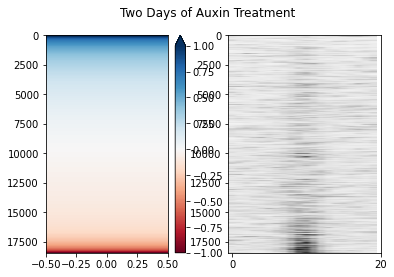

In [128]:
plot_logFPKM_CTCF_binding(0.0, twoDay_RNAseq_change, ctcf_binding_file, 'Two Days of Auxin Treatment')

In [129]:
# Group FPKM data according to change in expression from untreated to 4days of auxin treatment
fourDay_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_4days', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
fourDay_RNAseq_change = generate_log10_deltaFPKM(fourDay_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_4days')

fourDay_RNAseq_change[0:3]

,tracking_id,locus,CTCF-AID_untreated,CTCF-AID_4days,chrom,start,end,TSS_loc_ref,log10FoldChange
48143,Mir6942,chr13:21478872-21494624,0.01,1150.606667,chr13,21478872,21494624,21494624.0,5.060927
48621,Mir7054,chr7:52258319-52271619,0.01,533.030000,chr7,52258319,52271619,52271619.0,4.726752
49182,Mir8109,chr8:88224803-88224920,0.01,425.101000,chr8,88224803,88224920,88224804.0,4.628492


Setting cutoff to: 0.0
Number of differentially expressed genes with this cutoff: 18554
Number of up-regulated genes: 9779
Number of down-regulated genes: 8775


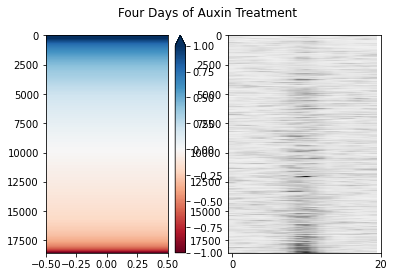

In [133]:
plot_logFPKM_CTCF_binding(0.0, fourDay_RNAseq_change, ctcf_binding_file, 'Four Days of Auxin Treatment')

In [131]:
# Group FPKM data according to change in expression following wash-off of auxin treatment
washOff_RNAseq_change = df_RNA_seq_FPKM_refTSS.filter(['tracking_id', 'locus', 'CTCF-AID_untreated', 'CTCF-AID_washoff', 'chrom', 'start', 'end', 'TSS_loc_ref'], axis=1)
washOff_RNAseq_change = generate_log10_deltaFPKM(washOff_RNAseq_change, 'CTCF-AID_untreated', 'CTCF-AID_washoff')

Setting cutoff to: 0.0
Number of differentially expressed genes with this cutoff: 18383
Number of up-regulated genes: 9356
Number of down-regulated genes: 9027


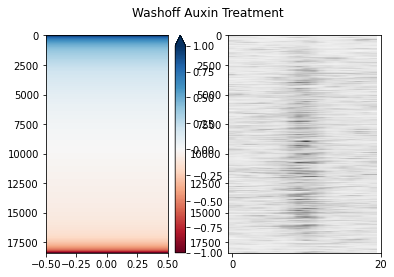

In [134]:
plot_logFPKM_CTCF_binding(0.0, washOff_RNAseq_change, ctcf_binding_file, 'Washoff Auxin Treatment')

In [11]:
# Parsing UCSC region into bioframe triple
RNA_seq_FPKM[['chrom', 'start', 'end']] = RNA_seq_FPKM.apply(lambda row: bioframe.parse_region_string(row['locus']), axis=1, result_type='expand')


### Visualizing without cut-off, without taking log of delta FPKM

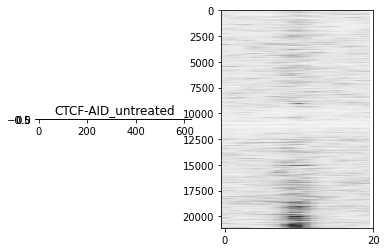

In [23]:



with bbi.open(sdir + "GSM2609195_CTCF_ChIP-exo_WT-untagged_untreated_rep1_ENC1_tagDensity.bw") as f:
    
    oneDay_DE_matrix = f.stackup(window_df['chrom'], window_df['TSS_loc_ref'] - 1000, window_df['TSS_loc_ref'] + 1000, bins=20)
    
fig, axis = plt.subplots(1,2)


logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
im = axis[0].imshow(logFPKM, cmap='RdBu', norm=colors.Normalize(vmin=0, vmax=1), aspect=0.001)
axis[0].title.set_text(window_df.columns.values[3])


fig = axis[1].imshow(matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
axis[1].set_xticks([0, 20])

# todo: set axis labels according to bp from TSS, instead of buckets, without changing scale
plt.show()

In [167]:
# split by positive and negative values
DE_up = window_df[window_df['delta'] > 0]
DE_down = window_df[window_df['delta'] < 0]

logFPKM_up = np.log10(DE_up['delta'])
midpoint = len(logFPKM_up)
logFPKM_down = np.log10(DE_down['delta'].abs())
- logFPKM_down
logFPKM = pd.concat([logFPKM_up, - logFPKM_down])
# logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
#window_df[-20:]
#logFPKM[-20:]

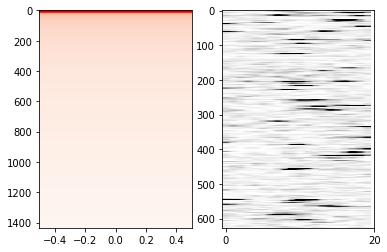

In [26]:
# fig, axis = plt.subplots(1,2)

# im = axis[0].imshow(logFPKM, cmap='RdBu', norm=colors.Normalize(vmin=-1, vmax=1), aspect=0.001)
# axis[0].title.set_text(window_df.columns.values[3])

cutoff = 1.0
oneDay_RNAseq_change_DEs = oneDay_RNAseq_change.loc[(oneDay_RNAseq_change['delta'].abs()) > cutoff]
window_df = oneDay_RNAseq_change_DEs


# split by positive and negative values
DE_up = window_df[window_df['delta'] > 0]
DE_down = window_df[window_df['delta'] < 0]

logFPKM_up = np.log10(DE_up['delta'])
midpoint = len(logFPKM_up)
logFPKM_down = np.log10(DE_down['delta'].abs())
logFPKM = pd.concat([logFPKM_up, - logFPKM_down])

fig, ax = plt.subplots(1,2)

logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))

minval=np.min(logFPKM)
maxval=np.max(logFPKM)
# if diverging, color negative values blue
if (minval < 0):
    divnorm=colors.TwoSlopeNorm(vmin=np.min(logFPKM), vcenter=0., vmax=np.max(logFPKM))
    fig = ax[0].imshow(logFPKM, cmap='RdBu', norm=divnorm, aspect=0.001)
# pcolormesh(your_data, cmap="coolwarm", norm=divnorm)
else:
    minval= 0
    fig = ax[0].imshow(logFPKM, cmap='Reds', norm=colors.Normalize(vmin=minval, vmax=maxval), aspect='auto')
    
    
# Plotting ctcf binding
fig = ax[1].imshow(oneDay_DE_matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
ax[1].set_xticks([0, 20])



plt.show()

In [ ]:
window_df = logFPKM

with bbi.open(sdir + "GSM2609195_CTCF_ChIP-exo_WT-untagged_untreated_rep1_ENC1_tagDensity.bw") as f:
    
    oneDay_DE_matrix = f.stackup(window_df['chrom'], window_df['TSS_loc_ref'] - 1000, window_df['TSS_loc_ref'] + 1000, bins=20)
    
fig, axis = plt.subplots(1,2)


logFPKM = np.transpose(np.expand_dims(logFPKM, axis=0))
im = axis[0].imshow(logFPKM, cmap='RdBu', norm=colors.Normalize(vmin=-1, vmax=1), aspect=0.001)
axis[0].title.set_text(window_df.columns.values[3])


fig = axis[1].imshow(matrix, cmap='gray_r', aspect='auto', vmin=0, vmax=100)
axis[1].set_xticks([0, 20])

# todo: set axis labels according to bp from TSS, instead of buckets, without changing scale
plt.show()

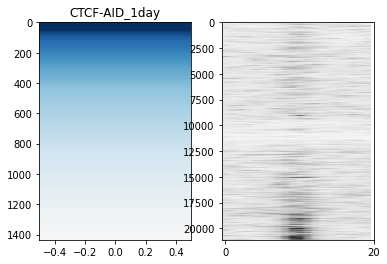

## Importing and cleaning RefSeq genes to get only transcripts

In [25]:
# Import RefSeq transcript annotations and find closest with bioframe

# Adding header from GTF filetype description: https://genome.ucsc.edu/FAQ/FAQformat.html#format4 
refGenes = pd.read_table('/scratch/pokorny/genomic_annotations/mm9.refGene.gtf', header=None, 
                         names=['seqname', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame',
                                'attributes'])

# Get transcripts only
refTranscripts = refGenes.loc[refGenes['feature'] == 'transcript'].copy()
refTranscripts = refTranscripts.rename(columns={'seqname' : 'chrom'})

# Create a column of the TSS start site (might be unnecessary, but we'll keep it here for reference later)
refTranscripts['TSS_loc'] = np.where((refTranscripts['strand'] == '+'), refTranscripts['start'], refTranscripts['end'])


In [26]:
# Cleaning out the randos
refTranscripts = refTranscripts.loc[False==( refTranscripts['chrom'].str.contains('_random'))]

In [27]:
np.unique(refTranscripts['chrom'])

array(['chr1', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15',
       'chr16', 'chr17', 'chr18', 'chr19', 'chr2', 'chr3', 'chr4', 'chr5',
       'chr6', 'chr7', 'chr8', 'chr9', 'chrX', 'chrY'], dtype=object)

In [28]:

df_RNA_seq_FPKM_refTSS = bioframe.overlap(RNA_seq_FPKM, refTranscripts, suffixes=('_1','_2'))

# Getting overlap to first, choose whichever has largest overlap
df_RNA_seq_FPKM_refTSS['overlap_len'] = df_RNA_seq_FPKM_refTSS.apply(lambda row: 
                                                                     np.abs(np.minimum(row['start_1'] , row['start_2']) - np.maximum(row['end_1'], row['end_2'])),
                                                                     axis=1)

# Get whoever has closest overlap (where distance is defined by squared distance between starts and ends)
df_RNA_seq_FPKM_refTSS['overlap_sq_dist'] = df_RNA_seq_FPKM_refTSS.apply(lambda row: 
                                                                     np.sqrt(np.abs(np.square(row['start_1'] - row['start_2']) - np.square(row['end_1'] - row['end_2']))),
                                                                     axis=1)

In [39]:
# Getting rid of the RNAseq rows that did not have an overlap with the RefSeq genes
print('Number of rows deleted: ')
print(df_RNA_seq_FPKM_refTSS['overlap_sq_dist'].isna().sum())
df_RNA_seq_FPKM_refTSS = df_RNA_seq_FPKM_refTSS.loc[False==df_RNA_seq_FPKM_refTSS['overlap_sq_dist'].isna()]



Number of rows deleted: 
0


In [46]:
df_RNA_seq_FPKM_refTSS['overlap_sq_dist'] = pd.to_numeric( df_RNA_seq_FPKM_refTSS['overlap_sq_dist'])


In [49]:
# Assign the transcript with the greatest amount of overlap to the RNAseq read (smallest squared overlap distance)
mindist_idx = df_RNA_seq_FPKM_refTSS.groupby(["chrom_1", "start_1","end_1"])['overlap_sq_dist'].idxmin()
df_RNA_seq_FPKM_refTSS = df_RNA_seq_FPKM_refTSS.loc[mindist_idx]

## Generating Fig 6. b: CTCF occupancy at the TSS of differentially expressed genes


** might need to re-arrange order: assign TSS to all the RNA-seq data first, then go back and pull out the deltas for each

step 1: use datasets generated above [oneDay_RNAseq_change, twoDay_RNAseq_change, fourDay_RNAseq_change, washOff_RNAseq_change]
step 2: import Chip-seq data corresponding to each

step 3: filter RNA-seq data: only get differentially expressed genes (assign some cutoff?)
step 4: generate TSS windows using just pandas to subtract 1000 and add 1000 from TSS for the "start" and "end" inputs of bbi.stackup